Final image: 
 [[ 79  74 120  55  22  56  36 121  14  19  17  39]
 [ 90  40 110 154 187 233 183  59  97 172 143 118]
 [113 143 213 118 139 117 110 220 203 113 123 143]
 [ 24 112  97  55  52  35  92  71   9 164 174 119]
 [173  98 194 133  85 123 131 117 168 107 176 105]
 [ 90 122 124 123 181 218 233 218 125 118 103  62]
 [136  76 118 196  14 169  81  27  58 163 187 131]
 [ 72 179 134  90 143 147 127  93 199  90  40 174]
 [119 135 135  83 162 155  91 125 215 126 154 116]
 [ 59  80 200 199 123 136 147 118  18 177  65  34]
 [123 166  93  45 104 102  68 133 167 149  65 174]
 [ 97 127  89 146 133 128 136 235 206  97  97 124]]


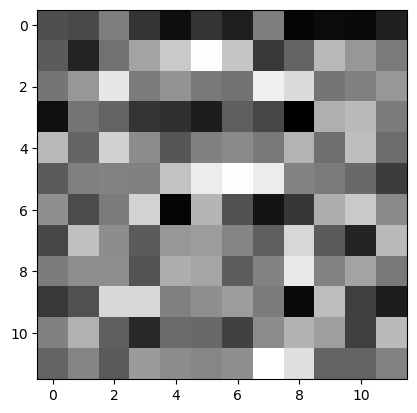

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from numpy import array
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center: #comparison function
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
      
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    
    power_val = [128,64,32,16,8,4,2,1]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]

    return val 
    
def lbp(img,height,width):
    img2=np.pad(img,pad_width=1) #padding the initial matrix
    height=img2.shape[0]
    width=img2.shape[1]
    img_lbp=np.zeros((height-2, width-2), dtype=int)

    for i in range(0, height-2):
        for j in range(0, width-2):
            img_lbp[i][j] = lbp_calculated_pixel(img2, i+1, j+1) #calling the necessary functions for lbp calculation and removing the padding
                
    
    return img_lbp

def mblbp(img,x,y):
    img1=[]
    avg=0
    
    for i in range(0,x-1,2):
        for j in range(0,y-1,2):
            avg=(int)((img[i][j]+img[i][j+1]+img[i+1][j]+img[i+1][j+1])/4) #calculating the average of 2x2 matrix 
            img1.append(avg)
    
    img1=np.array(img1)
    x=(int)(x/2)
    y=(int)(y/2)
    img1=img1.reshape(x,y)      
    return img1

def calc(img,height,width):
    if(height>12 and width>12):
        img=lbp(img,height,width) #sending img for lbp calculation
        img=mblbp(img,height,width) #sending img to the mblbp function 
        height=(int)(height/2) #reducing the size by 2
        width=(int)(width/2)
        return calc(img,height,width) #calling the function recursively
    
    return img
    
    
def main():
    img = cv2.imread("/Users/khushm/Desktop/emotion_rec/d1/dataset/test/neutral/im13.png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    plt.imshow(img, cmap='gray')
    height=img.shape[0]
    width=img.shape[1]
    
    img_lbp=calc(img,height,width) #passing the image and its size to the mblbp model
    print("Final image: \n",img_lbp)
    plt.imshow(img_lbp, cmap='gray')
    
                

if __name__ == '__main__':
    main()